In [26]:
# -*- coding: utf-8 -*-
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, SGD
import gym
import numpy as np
import random as rand

class Agent(object):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        
        self.node_num = 12
        self.learning_rate = 0.01
        self.epochs_cnt = 5               
        self.model = self.build_model()        
        
        self.discount_rate = 0.97
        self.penalty = -250

        self.episode_num = 500        
        
        self.replay_memory_limit = 2048
        self.replay_size = 32
        self.replay_memory = []

        self.epsilon = 0.99
        self.epsilon_decay = 0.2
        self.epsilon_min = 0.05
        
        self.moving_avg_size = 20
        self.reward_list= []
        self.count_list = []
        self.moving_avg_list = []
        
    def build_model(self):

        input_states = Input(shape=(1,self.state_size), name='input_states')

        x = (input_states)
        x = Dense(self.node_num, activation='tanh')(x)
        out_actions = Dense(self.action_size, activation='linear', name='output')(x)

        model = tf.keras.models.Model(inputs=[input_states], outputs=[out_actions])
        model.compile(optimizer=Adam(lr=self.learning_rate),
                      loss='mean_squared_error'
                     )
        model.summary()
        return model

    def train(self):
        for episode in range(self.episode_num):

            state = self.env.reset()
            Q, count, reward_tot = self.take_action_and_append_memory(episode, state)
            self.reward_list.append(reward_tot-self.penalty)
            self.count_list.append(count)
            self.moving_avg_list.append(self.moving_avg(self.count_list,self.moving_avg_size))                
            
            self.train_mini_batch(Q)
                
            if(episode % 10 == 0):
                print("episode:{}, moving_avg:{}, rewards_avg:{}".format(episode, self.moving_avg_list[-1], np.mean(self.reward_list)))
        self.save_model()

    def take_action_and_append_memory(self, episode, state):
        reward_tot = 0
        count = 0
        done = False
        episilon = self.get_episilon(episode)
        while not done:
            count+=1

            state_t = np.reshape(state,[1, 1, self.state_size])
            Q = self.model.predict(state_t)

            action = self.greed_search(episilon, episode, Q)

            state_next, reward, done, none = self.env.step(action)
            
            if done:
                reward = self.penalty 

            self.replay_memory.append([state_t, action, reward, state_next, done])

            if len(self.replay_memory) > self.replay_memory_limit:
                del self.replay_memory[0]

            reward_tot += reward
            state = state_next
        return Q, count, reward_tot

    def train_mini_batch(self, Q):
        array_state = []
        array_Q = []
        this_replay_size = self.replay_size
        if len(self.replay_memory) < self.replay_size:
            this_replay_size = len(self.replay_memory)
        
        for sample in rand.sample(self.replay_memory, this_replay_size):

            state_t,action,reward,state_next,done = sample

            if done:
                Q[0, 0, action] = reward
            else:
                state_t= np.reshape(state_next,[1,1,self.state_size])
                Q_new = self.model.predict(state_t)
                Q[0, 0, action] = reward + self.discount_rate * np.max(Q_new)
            array_state.append(state_t.reshape(1,self.state_size))
            array_Q.append(Q.reshape(1,self.action_size))

        array_state_t = np.array(array_state)
        array_Q_t = np.array(array_Q)
        hist = self.model.fit(array_state_t, array_Q_t, epochs=self.epochs_cnt, verbose=0)    

    def get_episilon(self, episode):
        result = self.epsilon * ( 1 - episode/(self.episode_num*self.epsilon_decay) )
        if result < self.epsilon_min:
            result = self.epsilon_min
        return result

    def greed_search(self, episilon, episode, Q):  
        if episilon > np.random.rand(1):
            action = self.env.action_space.sample()
        else:
            action = np.argmax(Q)
        return action

    def moving_avg(self, data, size=10):
        if len(data) > size:
            c = np.array(data[len(data)-size:len(data)]) 
        else:
            c = np.array(data) 
        return np.mean(c)
    
    def save_model(self):
        self.model.save("./model/dqn")
        print("*****end learing")

if __name__ == "__main__":
    agent = Agent()
    agent.train()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_states (InputLayer)    [(None, 1, 4)]            0         
_________________________________________________________________
dense_21 (Dense)             (None, 1, 12)             60        
_________________________________________________________________
output (Dense)               (None, 1, 2)              26        
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
episode:0, moving_avg:40.0, rewards_avg:39.0
episode:10, moving_avg:21.0, rewards_avg:20.0
episode:20, moving_avg:19.65, rewards_avg:19.61904761904762
episode:30, moving_avg:19.4, rewards_avg:18.967741935483872
episode:40, moving_avg:27.85, rewards_avg:23.146341463414632
episode:50, moving_avg:37.25, rewards_avg:25.745098039215687
episode:60, moving_avg:37.05, rewards_avg:27.37704918032787

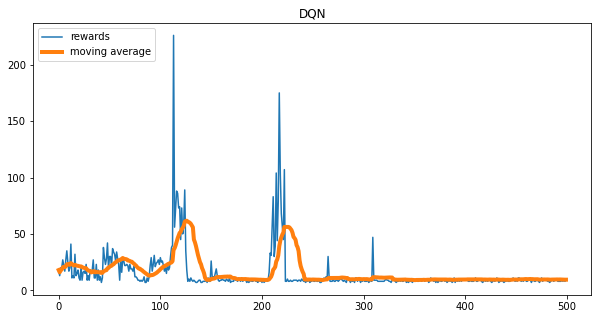

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(agent.reward_list, label='rewards')
plt.plot(agent.moving_avg_list, linewidth=4, label='moving average')
plt.legend(loc='upper left')
plt.title('DQN')
plt.show()

Text(0.5, 1.0, 'reword')

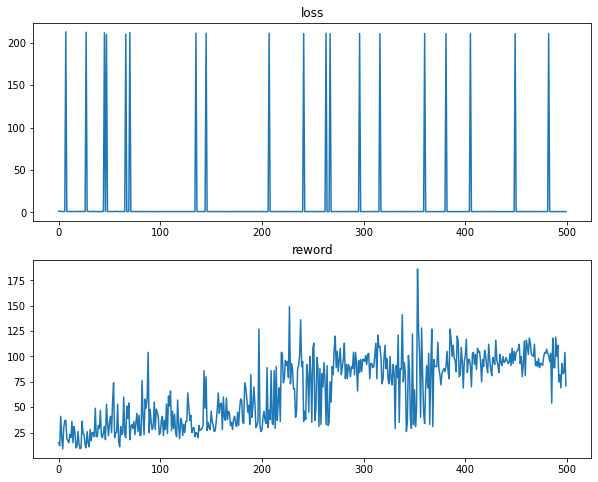

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.subplot(211) #numrows, numcols, plot_number
plt.plot(agent.loss)
plt.title('loss')

plt.subplot(212) #numrows, numcols, plot_number
plt.plot(agent.reward_list)
plt.title('reword')

Text(0.5, 1.0, 'reword')

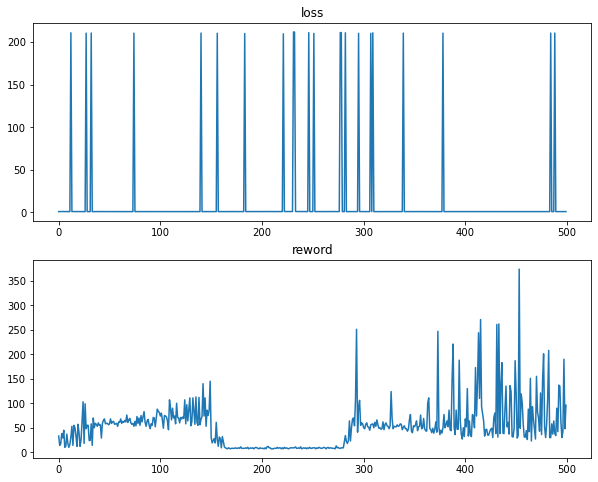

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.subplot(211) #numrows, numcols, plot_number
plt.plot(agent.loss)
plt.title('loss')

plt.subplot(212) #numrows, numcols, plot_number
plt.plot(agent.reward_list)
plt.title('reword')

In [341]:
import tensorflow.keras.backend as K
# y_pred = np.array([[0.6,0.4]])
# c = tf.random.stateless_categorical(tf.math.log(y_pred), 2)
# d = tf.cast(tf.random.stateless_categorical(tf.math.log(y_pred), 2), tf.float32)
# print("c,d", c,d)
# val = np.random.random((3, 4, 5))
# var = K.variable(value=val)
a = K.variable(value=np.array([[1,2],[3,4],[5,6]]))
b = K.variable(value=np.array([[2,2],[4,4],[6,6]]))
c = K.variable(value=np.array([[0.9, 0.1]]))

e = np.array(a)
# d = K.sum(a+b, axis=0)
# e=tf.random.categorical(tf.math.log(c), 2)
# d = np.random.choice(2, 1, p=c)
# y_pred = K.variable(value=[[0.4, 0.6]])
# y_pred_matrixs=tf.random.categorical(tf.math.log(y_pred), 2)
# print(y_pred_matrixs)
f = tf.keras.backend.random_binomial(shape=[1,1], p=c)
f

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 0.]], dtype=float32)>

In [185]:
k=1
w = K.variable(value=np.array([[0.5, 0.5]]))
cum_dist = tf.math.cumsum(w)
cum_dist /= cum_dist[-1]  # to account for floating point errors
unif_samp = tf.random.uniform((k,), 0, 1)
idxs = tf.searchsorted(cum_dist, unif_samp)
samp = tf.gather(a, idxs)  # samp contains the k weighted samples
samp

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[1., 2.]], dtype=float32)>

In [292]:
a = [0.1, 0.9]
choice_indices = K.random_uniform([1,1], minval=0, maxval=1, dtype=tf.int32)
print("*choice_indices:", choice_indices)
samples = tf.gather([0.6, 0.4], 1, axis=-1)
print("*samples:", samples)


*choice_indices: tf.Tensor([[0]], shape=(1, 1), dtype=int32)
*samples: tf.Tensor(0.4, shape=(), dtype=float32)


In [451]:
t = tf.random.categorical(tf.math.log([[0.3, 0.7]]), 1)
u = tf.gather([0.3, 0.7], t, axis=-1)
u

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.7]], dtype=float32)>

In [14]:
LOSS_CLIPPING = 1
advantages = [1,2,3,4,5]
advantages = [2,3,4,5,6]
c = -K.minimum(r*advantages, K.clip(r, 1-LOSS_CLIPPING, 1+LOSS_CLIPPING)*advantages)
c

NameError: name 'K' is not defined